#Text Processing and Linear Regression

In this notebook, we will look at the Amazon movie review dataset again, and try
- to predict the score and helpfulness from the actual review
- to find particular words that could indicate a good or bad review.

###Parse the data
This was an exercise in lesson #2, so we'll do it right away in a super concise pandas way.

In [1]:
import pandas as pd
with open("/Users/ruben/repo/personal/ga/DAT-23-NYC/data/amazon/small-movies.txt") as f:
    data = pd.DataFrame([{line[:line.find(':')]: line[line.find(':')+2:] 
                          for line in review.split('\nreview/')}
                         for review in ('\n' + f.read()).split('\nproduct/') if len(review) > 1])
    data['score'] = data.score.astype(float).astype(int)
    data['helpfulness'] = data.helpfulness.str.split('/').map(
        lambda frac: float(frac[0])/float(frac[1]) if frac[1] != '0' else None)

In [2]:
print len(data)
data.head(2)

1111


,helpfulness,productId,profileName,score,summary,text,time,userId
0,1,B003AI2VGA,"Brian E. Erland ""Rainbow Sphinx""",3,"""There Is So Much Darkness Now ~ Come For The ...","Synopsis: On the daily trek from Juarez, Mexic...",1182729600,A141HP4LYPWMSR
1,1,B003AI2VGA,Grady Harp,3,Worthwhile and Important Story Hampered by Poo...,THE VIRGIN OF JUAREZ is based on true events s...,1181952000,A328S9RN3U5M68


### Which words indicate a good or bad review?

####Adding a single text feature

Let's look at the most common words

In [3]:
words = pd.Series([word for line in data.summary.values for word in line.lower().split()]).value_counts()
words.head()

the      306
a        204
of       176
movie    131
great    110
dtype: int64

In [4]:
data['great'] = data.text.map(lambda x: x.find('great') > -1)
data.great.value_counts()

False    714
True     397
dtype: int64

#### Add text features

In [5]:
%%time
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.cross_validation import cross_val_score
cross_val_score
cv = CountVectorizer(stop_words = 'english', ngram_range=(1,2), max_features=100, 
                     min_df=.10, # only use words that appear at least some times (integer = absolute count)
                     max_df=.95)  # ignore words that appear too frequently
X, y = cv.fit_transform(data.text).todense(), data.score

CPU times: user 713 ms, sys: 173 ms, total: 885 ms
Wall time: 1.15 s


####Test some models
Let's try some linear models with different regularization parameters.

In [6]:
for n in xrange(-3, 5):
    alpha = 10 ** n
    print "alpha %10.4f  OLS %.4f Lasso %.4f Ridge %.4f" % \
        (alpha, 
         -cross_val_score(LinearRegression(), X, y, cv=10, scoring='mean_absolute_error').mean(),
         -cross_val_score(Lasso(alpha), X, y, cv=10, scoring='mean_absolute_error').mean(), 
         -cross_val_score(Ridge(alpha), X, y, cv=10, scoring='mean_absolute_error').mean())

alpha     0.0010  OLS 0.8311 Lasso 0.8279 Ridge 0.8311
alpha     0.0100  OLS 0.8311 Lasso 0.8170 Ridge 0.8311
alpha     0.1000  OLS 0.8311 Lasso 0.8648 Ridge 0.8310
alpha     1.0000  OLS 0.8311 Lasso 0.8751 Ridge 0.8305
alpha    10.0000  OLS 0.8311 Lasso 0.8751 Ridge 0.8266
alpha   100.0000  OLS 0.8311 Lasso 0.8751 Ridge 0.8137
alpha  1000.0000  OLS 0.8311 Lasso 0.8751 Ridge 0.8316
alpha 10000.0000  OLS 0.8311 Lasso 0.8751 Ridge 0.8611


Let's take `Ridge` with `alpha = 100`.

Note that `0.81` sounds like a reasonable mean absolute error when predicting the score from just tallying some words. However, also note that when our model would simply always predict a score of 4, we would have had an error of `.92`, so not _that_ much bigger:

In [7]:
import numpy as np
for score in range(6):
    print "Always %d gives MAE %.4f" % (score, np.abs(score - data.score).mean())

Always 0 gives MAE 4.2763
Always 1 gives MAE 3.2763
Always 2 gives MAE 2.3789
Always 3 gives MAE 1.5680
Always 4 gives MAE 0.9172
Always 5 gives MAE 0.7237


####Train model and analyze coefficients

In [8]:
model = Ridge(alpha=100)
model.fit(X, y)

Ridge(alpha=100, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, solver='auto', tol=0.001)

Worst: read, scene, plot, japanese, japan, hollywood, like, far, count, scenes, man, book, don, make, think
Best : movie, years, movies, tom, say, special, watching, does, time, times, life, best, love, great, excellent


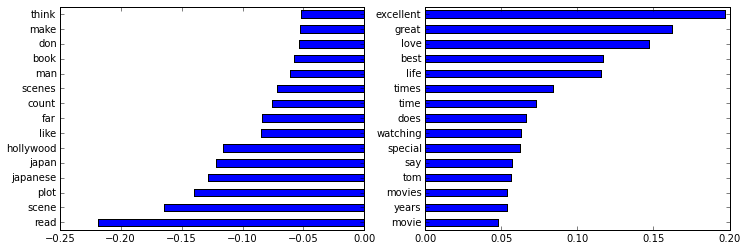

In [9]:
from matplotlib import pyplot as plt
%matplotlib inline
coef = pd.Series(model.coef_, index=cv.get_feature_names())
coef.sort()
top = 15
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
f = coef[:top].plot(kind='barh', ax=axes[0])
f = coef[-top:].plot(kind='barh', ax=axes[1])
print "Worst:", ", ".join(coef[:top].index)
print "Best :", ", ".join(coef[-top:].index)

- Seems like movies are better reviewed than books
- Japan and Hollywood seem to be more negative

### Which words could constitute helpfulness?

In [10]:
# left as exercise